### Packages

In [1]:
import pandas as pd
import json
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

d:\Anaconda\envs\RDS-Project\Lib\site-packages\mlflow\utils\requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


In [14]:
from dotenv import load_dotenv
import os

print("🔍 Environment Variables Loaded:")
print(f"AWS_ACCESS_KEY_ID: {'***' + os.getenv('MINIO_ACCESS_KEY', 'NOT SET')[-4:] if os.getenv('MINIO_ACCESS_KEY') else 'NOT SET'}")
print(f"AWS_SECRET_ACCESS_KEY: {'***' + os.getenv('MINIO_SECRET_ACCESS_KEY', 'NOT SET')[-4:] if os.getenv('MINIO_SECRET_ACCESS_KEY') else 'NOT SET'}")
print(f"AWS_DEFAULT_REGION: {os.getenv('AWS_DEFAULT_REGION', 'NOT SET')}")

🔍 Environment Variables Loaded:
AWS_ACCESS_KEY_ID: ***dmin
AWS_SECRET_ACCESS_KEY: ***dmin
AWS_DEFAULT_REGION: NOT SET


In [2]:
file_path = 'C:/Users/ldmag/Documents/GitHub/Code-Assignments-Projects/Projects/MLOps Drift Detection and Pipeline Optimization/data/Telco-Churn.csv'
data = pd.read_csv(file_path)

## Testing the environment with a baseline experiment

In [6]:
from cgi import test


def load_and_prep_telco_data(file_path): # very minimal preprocessing
    df = pd.read_csv(file_path)
    if 'TotalCharges' in df.columns:
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    if 'Churn' in df.columns:
        df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    categorical_columns = df.select_dtypes(include=['object']).columns
    if 'customerID' in df.columns:
        df = df.drop('customerID', axis=1)
    numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
    if 'Churn' in numeric_features:
        numeric_features.remove('Churn')
    categoric = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'DeviceProtection', 'TechSupport',
                'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'OnlineBackup']
    numeric_features = [n for n in numeric_features if n in df.columns and n !='Churn']
    categoric = [c for c in categoric if c in df.columns and c !='Churn']
    return df, numeric_features, categoric


def preprocessing_pipeline(numeric_features, categoric_features):
    steps = []

    if numeric_features:
        scaler = StandardScaler()
        steps.append(('num', scaler, numeric_features))
        print(f'Used StandardScaler for numeric variables')

    if categoric_features:
        scaler = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        steps.append(('cat', scaler, categoric_features))
        print(f'Used OneHotEncoder for categorical variables')

    preprocessor = ColumnTransformer(
        transformers=steps,
        remainder='drop'
    )

    return preprocessor

def train_baseline_model(df, numeric_features, categorical_features):
    X = df.drop('Churn', axis=1)
    y = df['Churn']

    features = numeric_features + categorical_features
    X = X[features]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    preprocessor = preprocessing_pipeline(numeric_features, categorical_features)

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'))
    ])
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    return model, metrics, (X_train, X_test, y_train, y_test)

def save(model, X_train, X_test, y_train, y_test, numeric, categoric):
    X_train_processed = model.named_steps['preprocessor'].transform(X_train)
    X_test_processed = model.named_steps['preprocessor'].transform(X_test)

    try:
        feat_names = model.named_steps['preprocessor'].get_feature_names_out()
    except:
        feat_names = [f'feature_{i}' for i in range(X_train_processed.shape[1])]

    X_trainDF = pd.DataFrame(X_train_processed, columns=feat_names)
    X_testDF = pd.DataFrame(X_test_processed, columns=feat_names)

    X_trainDF.to_csv('baseline_training_data-V2.csv', index=False)

    testLabelsDF = X_testDF.copy()
    testLabelsDF['Churn'] = y_test.values
    testLabelsDF.to_csv('baseline_test_data-V2.csv', index=False)

    raw_train = X_train.copy()
    raw_train['Churn'] = y_train.values
    raw_train.to_csv('baseline_raw_data-V2.csv', index=False)

    raw_test = X_test.copy()
    raw_test['Churn'] = y_test.values
    raw_test.to_csv('baseline_raw_test-V2.csv', index=False)

    feature_info = {
        'numeric_features': numeric,
        'categoric_features': categoric,
        'all_features': numeric + categoric,
        'processed_feature_names': feat_names.tolist(),
        'n_numeric': len(numeric),
        'n_categorical': len(categoric),
        'n_total_original': len(numeric) + len(categoric),
        'n_processed': len(feat_names),
        'preprocessing_info': {
            'numeric_transformer': 'StandardScaler',
            'categorical_transformer': 'OneHotEncoder(drop=first)',
            'handle_unknown': 'ignore'
        }
    }
    
    with open("feature_metadata.json", "w") as f:
        json.dump(feature_info, f, indent=2)
    print(f"Saved feature metadata")
    
    return X_train_processed, feature_info

def main():
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("telco-baseline")
    with mlflow.start_run(run_name="baseline_model_V3"):
        df, numeric_features, categoric_features = load_and_prep_telco_data(file_path)
        model, metrics, data_splits = train_baseline_model(df, numeric_features, categoric_features)
        X_train, X_test, y_train, y_test = data_splits
        processed_feats, feature_info = save(model, X_train, X_test, y_train, y_test, numeric_features, categoric_features)
        mlflow.log_param("model_type", "RandomForest")
        mlflow.log_param("n_estimators", 100)
        mlflow.log_param("max_depth", 10)
        #mlflow.log_param("test_size", 0.2)
        mlflow.log_param("random_state", 42)
        mlflow.log_param("dataset_size", len(df))
        mlflow.log_param("n_features_original", len(numeric_features + categoric_features))
        #mlflow.log_param("n_features_processed", feature_info['n_processed_features'])
        mlflow.log_param("n_numeric_features", len(numeric_features))
        mlflow.log_param("n_categorical_features", len(categoric_features))
        mlflow.log_param("churn_rate", df['Churn'].mean())
        mlflow.log_param("train_size", len(X_train))
        mlflow.log_param("test_size", len(X_test))
        for metric_name, value in metrics.items():
            mlflow.log_metric(metric_name, value)
        mlflow.sklearn.log_model(model, "Churn-RF-baseline-V2", registered_model_name="telco_churn_baseline", signature=mlflow.models.infer_signature(X_train, y_train))
        #X_train.to_csv("baseline_training_data.csv", index=False)
        mlflow.log_artifact("baseline_training_data-V2.csv")
        mlflow.log_artifact("baseline_test_data-V2.csv") 
        mlflow.log_artifact("baseline_raw_data-V2.csv")
        #mlflow.log_artifact("baseline-raw-test-V2.csv") # we technically don't need this stored
        mlflow.log_artifact("feature_metadata.json")
        print("\n Data artifacts logged")

        feature_importance = model.named_steps['classifier'].feature_importances_
        importance_df = pd.DataFrame({
            'feature': feature_info['processed_feature_names'],
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        importance_df.to_csv('baseline_featureImp.csv', index=False)
        mlflow.log_artifact('baseline_featureImp.csv')
        print('Logged feature importance')

        run_id = mlflow.active_run().info.run_id

        print(f'Experiment completed with run id: {run_id}.')

        return model, metrics, processed_feats, feature_info



if __name__ == "__main__":
    model, metrics, processed_feats, feature_info = main()

C:\Users\ldmag\AppData\Local\Temp\ipykernel_201600\1671554988.py:1: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  from cgi import test


Used StandardScaler for numeric variables
Used OneHotEncoder for categorical variables
Saved feature metadata


d:\Anaconda\envs\RDS-Project\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'telco_churn_baseline' already exists. Creating a new version of this model...
2025/10/28 03:11:53 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 


 Data artifacts logged
Logged feature importance
Experiment completed with run id: d8de8d4e37104125b85b56aa2fd9d37e.


## Simulating drift

In [ ]:
# This cell is now retired
'''
def load_artifact_minio(experiment_name, run_name):
    runs = mlflow.search_runs(experiement_ids=[experiment_name.experiment_id])
    baseline_id = runs.iloc[0]['run_id']

    datapath = mlflow.artifacts.download_artifacts(
        run_id=baseline_id,
        artifact_path='baseline_training_data-V2.csv'
    )

    data = pd.read_csv(datapath)

    baseline_model = mlflow.sklearn.load_model("models:/telco-baseline/latest")

    return data, baseline_model, baseline_id
'''

In [8]:
import pandas as pd
import numpy as np
import json
import mlflow
from pathlib import Path
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, ClassificationPreset, RegressionPreset
from evidently.test_suite import TestSuite
from evidently.tests import TestNumberOfDriftedColumns, TestShareOfDriftedColumns, TestColumnDrift
from evidently.tests import TestAccuracyScore, TestF1Score, TestRocAuc

class DriftAnalysis:
    def __init__(self):
        self.baseline_data = None
        self.baseline_model = None
        self.drift_report = None
        self.drift_test_suite = None
        self.numeric_features = None
        self.categorical_features = None
        
    def load_baseline(self, experiment_name="telco-baseline"):
        print("Loading baseline data and model from MLflow")
        
        # connection
        mlflow.set_tracking_uri("http://localhost:5000")
        
        try:
            # Load and error handling if unreadable
            self.baseline_data = pd.read_csv("baseline_raw_data-V2.csv")
            if 'Churn' in self.baseline_data.columns:
                print('Target detected - removing from loaded data')
                self.baseline_data = self.baseline_data.drop('Churn', axis=1)
            print(f"Baseline data loaded: {self.baseline_data.shape}")

            with open("feature_metadata.json", "r") as f:
                metadata = json.load(f)

            self.numeric_features = metadata['numeric_features']
            self.categorical_features = metadata['categoric_features']
            
            # model load
            self.baseline_model = mlflow.sklearn.load_model("models:/telco_churn_baseline@baselinev3")
            print(f"Model loaded: {type(self.baseline_model).__name__}")
            
            return True
            
        except Exception as e:
            print(f"Failed to load from MLflow: {e}")
            print("Troubleshoot from error message")
            return False
    
    def create_drift_simulation(self, strength=0.8):
        print(f"Creating drift simulation (strength: {strength})")
        
        if self.baseline_data is None:
            print("No baseline data loaded!")
            return None, None
        
        np.random.seed(42)  # le reproducibility
        drift_data = self.baseline_data.copy()

        drift_changes = []
        
        # This is for the numeric features - AI suggestion instead of using a generator; going to see if this works or not
        for i, col in enumerate(self.numeric_features):
            if i % 4 == 0:
                factor = 1 + strength + np.random.normal(0, 0.1, len(drift_data))
                drift_data[col] = drift_data[col] + factor
                drift_changes.append(f'{col}: {strength*100:.0f}% mean increase')

            elif i % 4 == 1:
                noise = np.random.normal(0, strength * drift_data[col].std(), len(drift_data))
                drift_data[col] = drift_data[col] + noise
                drift_changes.append(f"{col}: {strength*100:.0f}% variance increase")

            elif i % 4 == 2:
                drift_data[col] = drift_data[col].max() + drift_data[col].min() - drift_data[col]
                drift_changes.append(f"{col}: Distribution inverted")

            else:
                outlier_mask = np.random.binomial(1, 0.15, len(drift_data)).astype(bool)
                drift_data.loc[outlier_mask, col] = drift_data.loc[outlier_mask, col] * (1 + strength * 3)
                drift_changes.append(f"{col}: 15% extreme outliers added")

        # This is for categoric features - AI suggestion
        for i, col in enumerate(self.categorical_features):
            if col in drift_data.columns:
                
                unique_vals = drift_data[col].unique()
                
                if len(unique_vals) >= 2:
                    
                    if i % 3 == 0:
                        # Category redistribution - shift probabilities
                        mask = np.random.binomial(1, strength, len(drift_data)).astype(bool)
                        # Flip categories to simulate errors
                        if len(unique_vals) == 2:
                            # Binary categorical - flip values
                            val1, val2 = unique_vals[0], unique_vals[1]
                            swap_vals = drift_data.loc[mask, col].map({val1: val2, val2: val1})
                            drift_data.loc[mask, col] = swap_vals
                        else:
                            # Multi-category handling
                            current_vals = drift_data.loc[mask, col].values
                            new_vals = []
                            for val in current_vals:
                                avail = [val for val in unique_vals if val != val]
                                if avail:
                                    new_vals.append(np.random.choice(avail))
                                else:
                                    new_vals.append(val)
                            #new_vals = np.random.choice(unique_vals, size=len(current_vals)) #this throws an error
                            drift_data.loc[mask, col] = new_vals
                        
                        drift_changes.append(f"{col}: {strength*100:.0f}% category redistribution")
                    
                    elif i % 3 == 1:
                        # Introduce new category bias
                        # Heavily bias towards one category
                        most_common = drift_data[col].mode()[0]
                        bias_mask = np.random.binomial(1, strength * 0.6, len(drift_data)).astype(bool)
                        drift_data.loc[bias_mask, col] = most_common
                        drift_changes.append(f"{col}: {strength*60:.0f}% bias towards '{most_common}'")
                    
                    else:
                        # Complete category replacement for subset
                        replace_mask = np.random.binomial(1, strength * 0.4, len(drift_data)).astype(bool)
                        if len(unique_vals) >= 2:
                            # Replace with least common category
                            least_common = drift_data[col].value_counts().index[-1]
                            drift_data.loc[replace_mask, col] = least_common
                            drift_changes.append(f"{col}: {strength*40:.0f}% replaced with '{least_common}'")
        
        # from V1, adapted for this to simulate external factors - some of them
        if strength >= 0.7:
            print("Adding cross-feature relationship drift")
            
            # Create artificial correlations between features
            if len(self.numeric_features) >= 2:
                feat1, feat2 = self.numeric_features[:2]
                correlation_mask = drift_data[feat1] > drift_data[feat1].median()
                drift_data.loc[correlation_mask, feat2] = drift_data.loc[correlation_mask, feat2] * 1.5
                drift_changes.append(f"Cross-feature: {feat1} now affects {feat2}")
        
        # label generation
        base_churn_rate = 0.27  # Original Telco churn rate, see dataset information
        drift_churn_rate = base_churn_rate + (strength * 0.3)
        
        # Make churn rate dependent on some drifted features
        churn_probabilities = np.full(len(drift_data), drift_churn_rate)
        
        # Simulating high churn for high charges
        if 'MonthlyCharges' in drift_data.columns:
            high_charges = drift_data['MonthlyCharges'] > drift_data['MonthlyCharges'].quantile(0.8)
            churn_probabilities[high_charges] += 0.2
        
        # Generate labels
        drift_labels = np.random.binomial(1, np.clip(churn_probabilities, 0.1, 0.9))
        
        print(f"Drift applied to {len(drift_changes)} features:")
        for change in drift_changes[:8]:
            print(f"    {change}")
        if len(drift_changes) > 8:
            print(f"and {len(drift_changes) - 8} more changes")
        
        print(f"Original churn rate: ~27%, Drift churn rate: {drift_labels.mean():.1%}")
        
        
        #if drift_type == "covariate":
        #    for col in numeric_cols[:5]:
        #        shift = np.random.normal(strength, 0.1, len(drift_data)) # this should be a bit simpler I think
        #        drift_data[col] = drift_data[col] * (1 + shift)
        
        #elif drift_type == "concept":
        #    for col in numeric_cols[:5]:
        #        noise = np.random.normal(0, strength * drift_data[col].std(), len(drift_data))
        #        drift_data[col] = drift_data[col] + noise
        
        # Need to simulate synthetic labels too - COMMENTED OUT TO TEST ABOVE REFACTOR
        #drift_labels = np.random.binomial(1, 0.35, len(drift_data))
        
        return drift_data, drift_labels
    
    def run_analysis(self, drift_data, drift_threshold=0.3):
        print("Running drift analysis")
        
        self.drift_report = Report(metrics=[
            DataDriftPreset(drift_share=drift_threshold)
        ])
        
        try:
            self.drift_report.run(
                reference_data=self.baseline_data, 
                current_data=drift_data
            )
            
            print("Drift report created")
            
            report_dict = self.drift_report.as_dict()
            drift_results = self._extract_drift_summary(report_dict)
            
            return drift_results
            
        except Exception as e:
            print(f"Evidently analysis failed: {e}")
            return self._fallback_analysis(drift_data)
    
    def run_tests(self, drift_data):
        print("Running Evidently test suite")
        
        self.drift_test_suite = TestSuite(tests=[
            TestNumberOfDriftedColumns(gte=0, lte=len(self.baseline_data.columns)),
            TestShareOfDriftedColumns(gte=0, lte=0.8)
        ])
        
        try:
            self.drift_test_suite.run(
                reference_data=self.baseline_data,
                current_data=drift_data
            )
            
            # get results
            test_results = self.drift_test_suite.as_dict()
        
            tests = test_results.get('tests', [])
            passed_tests = sum(1 for test in tests if test.get('status') == 'SUCCESS')
            total_tests = len(tests)
            
            suite_results = {
                'total_tests': total_tests,
                'passed_tests': passed_tests,
                'failed_tests': total_tests - passed_tests,
                'overall_pass': passed_tests == total_tests
            }
            
            print(f"Test suite complete: {passed_tests}/{total_tests} tests passed")
            
            return suite_results
            
        except Exception as e:
            print(f"Test suite failed: {e}")
            return None
    
    def measure_impact(self, drift_data, drift_labels):
        print("Measuring impact of drift")
        
        if self.baseline_model is None:
            print(" No model loaded!")
            return None
        
        try:
            # Test model
            predictions = self.baseline_model.predict(drift_data)
            
            from sklearn.metrics import accuracy_score, f1_score
            
            accuracy = accuracy_score(drift_labels, predictions)
            f1 = f1_score(drift_labels, predictions)
            
            baseline_accuracy = 0.76  # had to set this from baseline experiment; TODO: Change each time model performance changes
            accuracy_drop = baseline_accuracy - accuracy
            accuracy_drop_pct = (accuracy_drop / baseline_accuracy) * 100
            
            impact_results = {
                'baseline_accuracy': baseline_accuracy,
                'drift_accuracy': accuracy,
                'accuracy_drop': accuracy_drop,
                'accuracy_drop_percentage': accuracy_drop_pct,
                'f1_score': f1,
                'predictions_total': len(predictions),
                'additional_errors': int(accuracy_drop * len(predictions))
            }
            
            print(f"Baseline accuracy: {baseline_accuracy:.1%}")
            print(f"Drift accuracy: {accuracy:.1%}")
            print(f"Performance drop: {accuracy_drop_pct:.1f}%")
            print(f"Additional errors: {impact_results['additional_errors']} per {len(predictions)} predictions")
            
            return impact_results
            
        except Exception as e:
            print(f"Impact analysis failed: {e}")
            return None
    
    def get_output(self, drift_results, test_results, impact_results):
        print("Generating output")
        
        # lets just see if this works before trying to do a dashboard, need to save it because the environment doesn't allow a two way connection
        # It does, keep for V2
        if self.drift_report:
            html_path = "evidently_report.html"
            self.drift_report.save_html(html_path)
            print(f"HTML report saved: {html_path}")
        
        return "evidently_report.html"
    
    def _extract_drift_summary(self, report_dict):
        try:
            # Navigate Evidently's report structure
            for metric in report_dict.get('metrics', []):
                if metric.get('metric') == 'DatasetDriftMetric':
                    result = metric.get('result', {})
                    
                    drift_by_columns = result.get('drift_by_columns', {})
                    drifted_features = [col for col, info in drift_by_columns.items() if info.get('drift_detected', False)]

                    numeric_drifted = [n for n in drifted_features if n in self.numeric_features]
                    categoric_drifted = [c for c in drifted_features if c in self.categorical_features]
                    
                    return {
                        'summary': {
                            'dataset_drift': result.get('dataset_drift', False),
                            'drift_score': result.get('drift_score', 0.0),
                            'drifted_features_count': len(drifted_features),
                            'total_features': len(drift_by_columns),
                            'drift_percentage': (len(drifted_features) / len(drift_by_columns)) * 100 if drift_by_columns else 0,
                            'drifted_features': drifted_features
                        },
                        'drift_by_type': {
                            'numeric_drifted': len(numeric_drifted),
                            'categorical_drifted': len(categoric_drifted),
                            'numeric_drifted_features': numeric_drifted,
                            'categorical_drifted_features': categoric_drifted
                        },
                        'results': drift_by_columns
                    }
            
            return {'summary': {'dataset_drift': False, 'error': 'Unable to parse results'}}
            
        except Exception as e:
            return {'error': f'Extraction failed: {e}'}

    def _fallback_analysis(self, drift_data):
        print("Using fallback analysis.")
        
        from scipy.stats import ks_2samp, chi2_contingency
        
        drift_results = []
        
        for col in self.numeric_features:
            if col in self.baseline_data.columns and col in drift_data.columns:
                ks_stat, p_value = ks_2samp(self.baseline_data[col], drift_data[col])
                drift_results.append({
                    'feature': col,
                    'type': 'numeric',
                    'test': 'ks_test',
                    'statistic': ks_stat,
                    'p_value': p_value,
                    'drift_detected': p_value < 0.05
                })
        
        for col in self.categorical_features:
            if col in self.baseline_data.columns and col in drift_data.columns:
                try:
                    # Chi-square test for categorical features
                    baseline_counts = self.baseline_data[col].value_counts()
                    drift_counts = drift_data[col].value_counts()
                    
                    all_categories = set(baseline_counts.index) | set(drift_counts.index)
                    baseline_aligned = [baseline_counts.get(cat, 0) for cat in all_categories]
                    drift_aligned = [drift_counts.get(cat, 0) for cat in all_categories]
                    
                    chi2_stat, p_value, _, _ = chi2_contingency([baseline_aligned, drift_aligned])
                    
                    drift_results.append({
                        'feature': col,
                        'type': 'categorical', 
                        'test': 'chi2_test',
                        'statistic': chi2_stat,
                        'p_value': p_value,
                        'drift_detected': p_value < 0.05
                    })
                    
                except Exception as e:
                    print(f" Chi2 test failed for {col}: {e}")
        
        drifted_features = [r['feature'] for r in drift_results if r['drift_detected']]
        numeric_drifted = [r['feature'] for r in drift_results if r['type'] == 'numeric' and r['drift_detected']]
        categorical_drifted = [r['feature'] for r in drift_results if r['type'] == 'categorical' and r['drift_detected']]
        
        return {
            'summary': {
                'dataset_drift': len(drifted_features) > 0,
                'drift_score': np.mean([r['statistic'] for r in drift_results]),
                'drifted_features_count': len(drifted_features),
                'total_features': len(drift_results),
                'drift_percentage': (len(drifted_features) / len(drift_results)) * 100,
                'drifted_features': drifted_features
            },
            'drift_by_type': {
                'numeric_drifted': len(numeric_drifted),
                'categorical_drifted': len(categorical_drifted),
                'numeric_drifted_features': numeric_drifted,
                'categorical_drifted_features': categorical_drifted
            },
            'method': 'fallback_statistical_tests',
            'detailed_results': drift_results
        }

    def create_robust_features_for_drift(self, drift_data):
        print("Creating robust features for drift simulation")
    
        robust_drift = drift_data.copy()
        features_added = []

        #if 'SeniorCitizen' not in robust_drift.columns:
        #    print("Adding missing SeniorCitizen column")
        #    robust_drift['SeniorCitizen'] = np.random.choice([0, 1], size=len(robust_drift), p=[0.84, 0.16])
        #    print("Added SeniorCitizen")
      
        #if 'OnlineBackup' not in robust_drift.columns:
        #   print("Adding missing OnlineBackup column")
        #    robust_drift['OnlineBackup'] = np.random.choice(['Yes', 'No', 'No internet service'], size=len(robust_drift), p=[0.35, 0.45, 0.20])
        #    print("Added OnlineBackup")
    
        if 'MonthlyCharges' in robust_drift.columns and 'TotalCharges' in robust_drift.columns:
            robust_drift['monthly_total_ratio'] = robust_drift['MonthlyCharges'] / (robust_drift['TotalCharges'] + 1)
            features_added.append('monthly_total_ratio')
            print("Added monthly_total_ratio")
    
        if 'TotalCharges' in robust_drift.columns and 'tenure' in robust_drift.columns:
            robust_drift['charge_per_month'] = robust_drift['TotalCharges'] / (robust_drift['tenure'] + 1)
            features_added.append('charge_per_month')
            print("Added charge_per_month")
    
        service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
        available_services = [col for col in service_cols if col in robust_drift.columns]
    
        if available_services:
            service_count = 0
            for col in available_services:
                service_count += (robust_drift[col] == 'Yes').astype(int)
            robust_drift['service_engagement'] = service_count
            features_added.append('service_engagement')
            print(f"Added service_engagement from {len(available_services)} services")
    
        if 'tenure' in robust_drift.columns:
            robust_drift['tenure_tier'] = pd.qcut(robust_drift['tenure'], 
                                                q=5, labels=['New', 'Short', 'Medium', 'Long', 'Veteran'], 
                                                duplicates='drop').astype(str)
            features_added.append('tenure_tier')
            print("Added tenure_tier")
    
        if 'MonthlyCharges' in robust_drift.columns:
            robust_drift['value_tier'] = pd.qcut(robust_drift['MonthlyCharges'], 
                                                q=4, labels=['Budget', 'Standard', 'Premium', 'Enterprise'], 
                                            duplicates='drop').astype(str)
            features_added.append('value_tier')
            print("Added value_tier")
    
        stability_score = 0
        if 'Contract' in robust_drift.columns:
            stability_score += (robust_drift['Contract'] == 'Two year').astype(int) * 2
            stability_score += (robust_drift['Contract'] == 'One year').astype(int) * 1
    
        if 'PaymentMethod' in robust_drift.columns:
            auto_pay = robust_drift['PaymentMethod'].str.contains('automatic', case=False, na=False)
            stability_score += auto_pay.astype(int)
    
        robust_drift['stability_score'] = stability_score
        features_added.append('stability_score')
        print("Added stability_score")
    
        print(f"Total robust features added: {len(features_added)}")
        print(f"Robust drift data shape: {robust_drift.shape}")
    
        return robust_drift

    def create_drift_simulation_with_robust_features(self, strength):
        print(f"Creating drift simulation with robust features (strength: {strength})")
    
    # Use your existing drift simulation method
        drift_data, drift_labels = self.create_drift_simulation(strength)
    
        if drift_data is None:
            print("Failed to create base drift simulation")
            return None, None
    
    # Add robust features to drift data
        robust_drift_data = self.create_robust_features_for_drift(drift_data)
    
        print(f"Robust drift simulation complete: {robust_drift_data.shape}")
    
        return robust_drift_data, drift_labels

def run_complete_analysis():

    print("Starting Evidently Analysis")
    
    # Initialize analyzer
    analyzer = DriftAnalysis()
    
    # Set up MLflow tracking
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("telco-driftAnalysis")
    
    with mlflow.start_run(run_name="evidently_analysis_V2"):
        
        if not analyzer.load_baseline():
            print("Cannot proceed without baseline data. Run baseline experiment first!")
            return
        
        drift_data, drift_labels = analyzer.create_drift_simulation(0.8)
        if drift_data is None:
            return
        
        drift_results = analyzer.run_analysis(drift_data, 0.1)
        
        test_results = analyzer.run_tests(drift_data)
        
        impact_results = analyzer.measure_impact(drift_data, drift_labels)
        
        html_report = analyzer.get_output(drift_results, test_results, impact_results)
        
        if drift_results and 'summary' in drift_results:
            mlflow.log_metric("drift_detected", 1 if drift_results.get('dataset_drift') else 0)
            mlflow.log_metric("drift_percentage", drift_results.get('drift_percentage', 0))
            mlflow.log_metric("drifted_features_count", drift_results.get('drifted_features_count', 0))

            if 'drift_by_type' in drift_results:
                type_info = drift_results['drift_by_type']
                mlflow.log_metric('numeric_features_drifted', type_info.get('numeric_drifted', 0))
                mlflow.log_metric('categorical_features_drifted', type_info.get('categorical_drifted', 0))
        
        if test_results:
            mlflow.log_metric("tests_passed", test_results.get('passed_tests', 0))
            mlflow.log_metric("tests_total", test_results.get('total_tests', 0))
        
        if impact_results:
            mlflow.log_metric("accuracy_drop_percentage", impact_results.get('accuracy_drop_percentage', 0))
            mlflow.log_metric("drift_accuracy", impact_results.get('drift_accuracy', 0))
            #mlflow.log_metric("additional_errors", impact_results.get('additional_errors', 0)) # Terminal is for errors, not artifacts
        
        # Dropping this artifact because PSQL doesn't like this
        #if Path("evidently_report.html").exists():
        #    mlflow.log_artifact("evidently_report.html")
        
        print("\\n Analysis Complete")
        print("Key metrics logged")
        
        return analyzer, drift_results, test_results, impact_results

if __name__ == "__main__":
    try:
        results = run_complete_analysis()
        print("\\ Analysis completed")
        
    except Exception as e:
        print(f"\\n Analysis failed: {e}. See tracebacks")

Starting Evidently Analysis
Loading baseline data and model from MLflow
Target detected - removing from loaded data
Baseline data loaded: (5634, 19)


Model loaded: Pipeline
Creating drift simulation (strength: 0.8)
Adding cross-feature relationship drift
Drift applied to 20 features:
    tenure: 80% mean increase
    MonthlyCharges: 80% variance increase
    TotalCharges: Distribution inverted
    gender: 80% category redistribution
    Partner: 48% bias towards 'No'
    Dependents: 32% replaced with 'Yes'
    PhoneService: 80% category redistribution
    MultipleLines: 48% bias towards 'No'
and 12 more changes
Original churn rate: ~27%, Drift churn rate: 55.1%
Running drift analysis
Drift report created
Running Evidently test suite
Test suite complete: 2/2 tests passed
Measuring impact of drift
Baseline accuracy: 76.0%
Drift accuracy: 45.5%
Performance drop: 40.2%
Additional errors: 1719 per 5634 predictions
Generating output
HTML report saved: evidently_report.html
\n Analysis Complete
Key metrics logged
\ Analysis completed


## Apply base interventions

This applies retraining and rollback actions within the pipeline as an experiment and estimates performance under drift conditions. 

In [ ]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import time
import json
import os
import boto3
from dotenv import load_dotenv
from pathlib import Path

from DriftDetection import DriftAnalysis

load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv("MINIO_ACCESS_KEY")
AWS_SECRET_ACCESS_KEY = os.getenv("MINIO_SECRET_ACCESS_KEY")
MLFLOW_S3_ENDPOINT_URL = os.getenv("MLFLOW_S3_ENDPOINT_URL")

class DriftInterventions:  
    def __init__(self):
        self.baseline_model = None
        self.baseline_data = None
        self.drift_data = None
        self.drift_labels = None
        self.intervention_results = {}
        
    def load_baseline_and_drift(self):
        print("Loading baseline model and generating drift data")
        
        drift_analyzer = DriftAnalysis()
        
        if not drift_analyzer.load_baseline():
            print("Cannot load baseline. Run baseline_fixed.py first!")
            return False
            
        # Generate drift data
        self.drift_data, self.drift_labels = drift_analyzer.create_drift_simulation(0.8)
        
        if self.drift_data is None:
            print("Failed to generate drift data!")
            return False
            
        # Store references
        self.baseline_data = drift_analyzer.baseline_data
        self.baseline_model = drift_analyzer.baseline_model
        
        print(f"Baseline data: {self.baseline_data.shape}")
        print(f"Drift data: {self.drift_data.shape}")
        print(f"Baseline model loaded")
        
        return True
    
    def test_intervention_retraining(self):
        # test retraining strategy
        print("\\n Testing RETRAINING intervention")
        
        start_time = time.time()
        
        # split
        X_drift_train, X_drift_test, y_drift_train, y_drift_test = train_test_split(
            self.drift_data, self.drift_labels, 
            test_size=0.3, random_state=42, stratify=self.drift_labels
        )
        
        # retrain
        print("Retraining model on drift data")
        retrained_model = RandomForestClassifier(
            n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'
        )
        
        if hasattr(self.baseline_model, 'named_steps'):
            # Use the same preprocessing pipeline
            from sklearn.pipeline import Pipeline
            retrained_pipeline = Pipeline([
                ('preprocessor', self.baseline_model.named_steps['preprocessor']),
                ('classifier', retrained_model)
            ])
            
            retrained_pipeline.fit(X_drift_train, y_drift_train)
            retrained_predictions = retrained_pipeline.predict(X_drift_test)
            y_pred_proba = retrained_pipeline.predict_proba(X_drift_test)[:, 1]
            
            model_to_save = retrained_pipeline
            print('Pipeline retrained')
            
        else:
            # Direct model training
            retrained_model.fit(X_drift_train, y_drift_train)
            retrained_predictions = retrained_model.predict(X_drift_test)
            y_pred_proba = retrained_model.predict_proba(X_drift_test)[:, 1]
            model_to_save = retrained_model
            print('Model was retrained directly from artifact, sklearn pipeline was not used')
        
        training_time = time.time() - start_time
        
        # Evaluate retrained model
        retrained_accuracy = accuracy_score(y_drift_test, retrained_predictions)
        retrained_auc = roc_auc_score(y_drift_test, y_pred_proba)
        retrained_f1 = f1_score(y_drift_test, retrained_predictions)
        
        # Compare with baseline performance on same drift data
        baseline_predictions = self.baseline_model.predict(X_drift_test)
        baseline_accuracy = accuracy_score(y_drift_test, baseline_predictions)
        baseline_f1 = f1_score(y_drift_test, baseline_predictions)
        baseline_auc = roc_auc_score(y_drift_test, y_pred_proba)
        
        accuracy_improvement = retrained_accuracy - baseline_accuracy
        f1_improvement = retrained_f1 - baseline_f1
        auc_improvement = retrained_auc - baseline_auc
        
        results = {
            'intervention_type': 'retraining',
            'retrained_accuracy': retrained_accuracy,
            'retrained_f1': retrained_f1,
            'retrained_auc': retrained_auc,
            'baseline_accuracy_on_drift': baseline_accuracy,
            'baseline_f1_on_drift': baseline_f1,
            'baseline_auc_on_drift': baseline_auc, 
            'accuracy_improvement': accuracy_improvement,
            'f1_improvement': f1_improvement,
            'auc_improvement': auc_improvement,
            'training_time_seconds': training_time,
            'training_samples': len(X_drift_train)
        }
        
        print(f"Retraining complete! Time: {training_time:.1f}s")
        print(f"Baseline accuracy on drift: {baseline_accuracy:.3f}")
        print(f"Retrained accuracy: {retrained_accuracy:.3f}")
        print(f"Improvement: {accuracy_improvement:+.3f} ({accuracy_improvement/baseline_accuracy*100:+.1f}%)")
        
        self.intervention_results['retraining'] = results
        return model_to_save, results
    
    def test_intervention_rollback(self):
        print("\\n Testing ROLLBACK intervention")
        
        # Since we have just one baseline with a single version, we will need to simulate a rollback by testing it on drifted data instead.
        # Another limitation - baseline used the entire dataset, so we have no additional data that is unseen. Could actually do this for a future version.
        
        rollback_predictions = self.baseline_model.predict(self.drift_data)
        y_pred_proba = self.baseline_model.predict_proba(self.drift_data)[:, 1]

        rollback_accuracy = accuracy_score(self.drift_labels, rollback_predictions)
        rollback_auc = roc_auc_score(self.drift_labels, y_pred_proba)
        rollback_f1 = f1_score(self.drift_labels, rollback_predictions)
        
        # Calculate degradation from original baseline performance
        original_baseline_accuracy = 0.76
        accuracy_degradation = original_baseline_accuracy - rollback_accuracy #this should in fact be the same
        
        results = {
            'intervention_type': 'rollback',
            'rollback_accuracy': rollback_accuracy,
            'rollback_f1': rollback_f1,
            'rollback_auc': rollback_auc,
            'original_baseline_accuracy': original_baseline_accuracy,
            'accuracy_degradation': accuracy_degradation,
            'degradation_percentage': (accuracy_degradation / original_baseline_accuracy) * 100,
        }
        
        print(f"Original baseline accuracy: {original_baseline_accuracy:.3f}")
        print(f"Rollback accuracy on drift: {rollback_accuracy:.3f}")
        print(f"Performance degradation: {accuracy_degradation:.3f} ({results['degradation_percentage']:.1f}%)")
        
        self.intervention_results['rollback'] = results
        return self.baseline_model, results
    

def run_intervention_testing():
    print("Starting Interventions")
    
    tester = DriftInterventions()
    
    # Set up MLflow
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("telco-base-interventions")
    
    # Load baseline and generate drift
    if not tester.load_baseline_and_drift():
        return
    
    with mlflow.start_run(run_name="basic_interventions-V2"):
        
        # Test each intervention
        print("\\n Testing Interventions:")
        
        # run retraining
        retrained_model, retraining_results = tester.test_intervention_retraining()
        
        # run rollback  
        rollback_model, rollback_results = tester.test_intervention_rollback()
        
        # Log results to MLflow
        print("\\n Logging results to MLflow.")
        
        for intervention_name, results in tester.intervention_results.items():
            for metric_name, value in results.items():
                if isinstance(value, (int, float)):
                    mlflow.log_metric(f"{intervention_name}_{metric_name}", value)
                else:
                    mlflow.log_param(f"{intervention_name}_{metric_name}", str(value))
        
        # Save results
        results_fp = "intervention_results.json"
        with open(results_fp, "w") as f:
            json.dump({
                'intervention_results': tester.intervention_results
            }, f, indent=2, default=str)

        try:
            if os.path.exists(results_fp):
                mlflow.log_artifact("intervention_results.json")
                print('Artifact logged')
            else:
                print('File not found')
        except Exception as e:
            print(f'Unable to log artifact: {e}. Results saved locally as {results_fp}')
        
        print("\\n Tests Complete")
        print("\\n Summary:")
        print(f"   • {len(tester.intervention_results)} interventions tested")
        print(f"   • Results logged to MLflow experiment")
        
        return tester.intervention_results

if __name__ == "__main__":
    try:
        results = run_intervention_testing()
        print("\\n Intervention testing completed")
        
    except Exception as e:
        print(f"\\n Intervention testing failed: {e}")

Starting Interventions
Loading baseline model and generating drift data
Loading baseline data and model from MLflow
Target detected - removing from loaded data
Baseline data loaded: (5634, 19)


Model loaded: Pipeline
Creating drift simulation (strength: 0.8)
Adding cross-feature relationship drift
Drift applied to 20 features:
    tenure: 80% mean increase
    MonthlyCharges: 80% variance increase
    TotalCharges: Distribution inverted
    gender: 80% category redistribution
    Partner: 48% bias towards 'No'
    Dependents: 32% replaced with 'Yes'
    PhoneService: 80% category redistribution
    MultipleLines: 48% bias towards 'No'
and 12 more changes
Original churn rate: ~27%, Drift churn rate: 55.1%
Baseline data: (5634, 19)
Drift data: (5634, 19)
Baseline model loaded
\n Testing Interventions:
\n Testing RETRAINING intervention
Retraining model on drift data
Pipeline retrained
Retraining complete! Time: 0.5s
Baseline accuracy on drift: 0.458
Retrained accuracy: 0.533
Improvement: +0.075 (+16.4%)
\n Testing ROLLBACK intervention
Original baseline accuracy: 0.760
Rollback accuracy on drift: 0.460
Performance degradation: 0.300 (39.5%)
\n Logging results to MLflow.
Unable 

## Testing robust pipeline

This will manipulate the training data with more preprocessing that should theoretically make it more resistant to drift.

In [ ]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
import json
from pathlib import Path

load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv("MINIO_ACCESS_KEY")
AWS_SECRET_ACCESS_KEY = os.getenv("MINIO_SECRET_ACCESS_KEY")
MLFLOW_S3_ENDPOINT_URL = os.getenv("MLFLOW_S3_ENDPOINT_URL")

from DriftDetection import DriftAnalysis

def create_features(df, numeric_features, categorical_features):
    print("Creating robust features compatible with existing pipeline")
    
    robust_df = df.copy()
    new_numeric_features = []
    new_categorical_features = []
    
    # Ratio features, found this gem on Kaggle
    if 'MonthlyCharges' in numeric_features and 'TotalCharges' in numeric_features:
        robust_df['monthly_total_ratio'] = robust_df['MonthlyCharges'] / (robust_df['TotalCharges'] + 1)
        new_numeric_features.append('monthly_total_ratio')
        print("Added monthly_total_ratio")
    
    if 'TotalCharges' in numeric_features and 'tenure' in numeric_features:
        robust_df['charge_per_month'] = robust_df['TotalCharges'] / (robust_df['tenure'] + 1)
        new_numeric_features.append('charge_per_month')
        print("Added charge_per_month")
    
    # Service Score
    service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    available_services = [col for col in service_cols if col in categorical_features]
    
    if available_services:
        service_count = 0
        for col in available_services:
            service_count += (robust_df[col] == 'Yes').astype(int)
        robust_df['service_engagement'] = service_count
        new_numeric_features.append('service_engagement')
        print(f"Added service_engagement from {len(available_services)} services")
    
    # New Tenure representation
    if 'tenure' in numeric_features:
        robust_df['tenure_tier'] = pd.qcut(robust_df['tenure'], 
                                         q=4, labels=['New', 'Short', 'Medium', 'Long'], 
                                         duplicates='drop').astype(str)
        new_categorical_features.append('tenure_tier')
        print("Added tenure_tier")
    
    # Value representation
    if 'MonthlyCharges' in numeric_features:
        robust_df['value_tier'] = pd.qcut(robust_df['MonthlyCharges'], 
                                        q=3, labels=['Budget', 'Standard', 'Premium'], 
                                        duplicates='drop').astype(str)
        new_categorical_features.append('value_tier')
        print(" Added value_tier")
    
    # Customer stability score, AI suggestion
    stability_score = 0
    if 'Contract' in categorical_features:
        stability_score += (robust_df['Contract'] == 'Two year').astype(int) * 2
        stability_score += (robust_df['Contract'] == 'One year').astype(int) * 1
    
    if 'PaymentMethod' in categorical_features:
        auto_pay = robust_df['PaymentMethod'].str.contains('automatic', case=False, na=False)
        stability_score += auto_pay.astype(int)
    
    robust_df['stability_score'] = stability_score
    new_numeric_features.append('stability_score')
    print("Added stability_score")
    
    # Update feature lists
    #if not isinstance(new_numeric_features, list):
    #    new_numeric_features = []
    #if not isinstance(new_categorical_features, list):
    #    new_categorical_features = []

    updated_numeric = numeric_features + new_numeric_features
    updated_categorical = categorical_features + new_categorical_features
    
    print(f"Added {len(new_numeric_features)} numeric and {len(new_categorical_features)} categorical features")
    
    return robust_df, updated_numeric, updated_categorical

def add_adversarial_training_examples(df, augmentation_factor=0.2):
    # This is inspired by adversarial data augmentation, with some AI assistance for scenarios because I'm stupid
    print(f"Adding adversarial examples ({augmentation_factor*100:.0f}% of dataset)")
    
    base_size = len(df)
    n_augment = int(base_size * augmentation_factor)
    augmented_examples = []
    
    # Simulating a change in economy; inflation -> increase in monthly charge -> higher churn
    economic_sample = df.sample(n=n_augment//3, random_state=42).copy()
    if 'MonthlyCharges' in economic_sample.columns:
        # Customers with higher charges become more likely to churn
        high_charge_mask = economic_sample['MonthlyCharges'] > economic_sample['MonthlyCharges'].quantile(0.6)
        economic_sample.loc[high_charge_mask, 'Churn'] = 1
    augmented_examples.append(economic_sample)
    
    # Simulating new competition
    competitive_sample = df.sample(n=n_augment//3, random_state=43).copy()
    if 'InternetService' in competitive_sample.columns:
        fiber_customers = competitive_sample['InternetService'] == 'Fiber optic'
        # Simulate competitor targeting fiber customers
        competitive_sample.loc[fiber_customers, 'Churn'] = np.random.choice([0, 1], 
                                                                          size=fiber_customers.sum(), 
                                                                          p=[0.4, 0.6])
    augmented_examples.append(competitive_sample)
    
    # New services take priority -> more emphasis on Streaming -> less churn
    usage_sample = df.sample(n=n_augment//3, random_state=44).copy()
    streaming_cols = ['StreamingTV', 'StreamingMovies']
    has_streaming = False
    for col in streaming_cols:
        if col in usage_sample.columns:
            has_streaming = usage_sample[col] == 'Yes'
            break
    
    if isinstance(has_streaming, pd.Series) and has_streaming.sum() > 0:
        usage_sample.loc[has_streaming, 'Churn'] = np.random.choice([0, 1], 
                                                                   size=has_streaming.sum(), 
                                                                   p=[0.8, 0.2])
    augmented_examples.append(usage_sample)
    
    # concat dataset
    robust_dataset = pd.concat([df] + augmented_examples, ignore_index=True)
    
    print(f"Added {len(robust_dataset) - base_size} adversarial examples")
    print(f"Final dataset size: {len(robust_dataset)} (was {base_size})")

    print(f"\nDEBUG - Feature Lists After Adv Examples:")
    print(f"robust_numeric type: {robust_dataset.dtypes}")

    return robust_dataset

def create_robust_baseline():
    print("Creating new baseline")

    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("telco-robust-baseline")

    with mlflow.start_run(run_name='robust_baseline_V1'):

    
        print("Loading data")
    
        df = pd.read_csv(file_path)
        print(f"Original shape: {df.shape}")
    
        # Repeat preprocssing pipe
        if 'TotalCharges' in df.columns:
            df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
            df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
    
        if 'Churn' in df.columns:
            df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
        
        if 'customerID' in df.columns:
            df = df.drop('customerID', axis=1)
    
        # Define feature types (same as your baseline)
        numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
        categorical_features = [
            'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
            'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen'
        ]
    
        numeric_features = [f for f in numeric_features if f in df.columns and f != 'Churn']
        categorical_features = [f for f in categorical_features if f in df.columns and f != 'Churn']

        print(f'\n DEBUG - Numeric and Categoric Lists defined')

        # apply feature creation and new samples
        robust_df, robust_numeric, robust_categorical = create_features(
            df, numeric_features, categorical_features)

        print(f'\n DEBUG - Testing Dataframe integrity')
    
        robust_df = add_adversarial_training_examples(robust_df, augmentation_factor=0.15)
        print(f'\n DEBUG - Testing sample injections')
    
        # Training
        print(f'\n DEBUG - Starting training')
        X = robust_df.drop('Churn', axis=1)
        y = robust_df['Churn']

        print(f'\n DEBUG - Target dropped, XY splits created')
    
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)

        print(f'\n DEBUG - Train-Test splits created')
    
    # Use your existing preprocessing pipeline
    #from sklearn.preprocessing import StandardScaler, OneHotEncoder
    #from sklearn.compose import ColumnTransformer
    #from sklearn.pipeline import Pipeline
    #from sklearn.ensemble import RandomForestClassifier
    
        preprocessor = ColumnTransformer([
            ('num', RobustScaler(), robust_numeric),
            ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), robust_categorical)
        ], remainder='drop')

        print(f'\n DEBUG - Preprocessor created')
    
        robust_model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'
            ))
        ])
    
        robust_model.fit(X_train, y_train)

        train_score = robust_model.score(X_train, y_train)
        test_score = robust_model.score(X_test, y_test)

        y_pred = robust_model.predict(X_test)
        y_prob = robust_model.predict_proba(X_test)[:, 1]

        test_accuracy = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred)
        test_auc = roc_auc_score(y_test, y_prob)

        print(f'\n DEBUG - Robust model fitted')

        mlflow.log_param("model_type", "RandomForest")
        mlflow.log_param("robust_features", True)

        mlflow.log_metric("test_score", test_score)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("test_auc", test_auc)

        from mlflow.models.signature import infer_signature

        mlflow.sklearn.log_model(
            robust_model, 'robustRF_model',
            signature=infer_signature(X_train, y_train), registered_model_name='telco-robust-baseline'
        )
    
        robust_training_data = X_train.copy()
        robust_training_data['Churn'] = y_train.values
        robust_training_data.to_csv("baseline_robustTrain_data.csv", index=False)
        mlflow.log_artifact('baseline_robustTrain.csv')
        print(f'\n DEBUG - Created training data artifact locally.')
    
        robust_feature_info = {
            'numeric_features': robust_numeric,
            'categorical_features': robust_categorical,
            'all_features': robust_numeric + robust_categorical,
            'n_numeric': len(robust_numeric),
            'n_categorical': len(robust_categorical),
            'n_total': len(robust_numeric) + len(robust_categorical), # this caused a damned error that took me 2 hours to debug
            'robust_features_added': True,
            'adversarial_augmentation': True,
            'augmentation_factor': 0.15
        }
    
        with open("feature_metadata_robust.json", "w") as f:
            json.dump(robust_feature_info, f, indent=2)
            print('Feature information logged.')
    
        print("Robust baseline created.")
    
    return robust_model, robust_feature_info

class RobustTrainingABTest:
    
    def __init__(self):
        self.original_analyzer = None
        self.robust_model = None
        self.results = {}
    
    def load_both_baselines(self):
        print("Loading both baseline models for comparison")
        
        # Load baseline V4
        self.original_analyzer = DriftAnalysis()
        if not self.original_analyzer.load_baseline():
            print("Cannot load original baseline")
            return False
        
        # Load robust baseline (if exists, otherwise create it)
        try:
            import json
            with open("feature_metadata_robust.json", "r") as f:
                robust_metadata = json.load(f)
            
            # Load robust model from MLflow (would be registered)
            import mlflow.sklearn
            self.robust_model = mlflow.sklearn.load_model("models:/telco-robust-baseline/latest")
            print("Loaded existing robust model from MLflow")
            
        except:
            print("Robust baseline not found, auto-creating.")
            self.robust_model, robust_metadata = create_robust_baseline()
        
        print("Baselines loaded successfully")
        return True
    
    def run_test(self):
        print("\n Running A/B test")
    
        # Generate drift for original model
        print("\n Creating drift for original model")
        original_drift_data, drift_labels = self.original_analyzer.create_drift_simulation(0.8)
    
        if original_drift_data is None:
            print("Failed to create original drift data")
            return None
    
        # Generate drift for robust model (with robust features)
        print("\n Creating drift for robust model")
        robust_drift_data, robust_drift_labels = self.original_analyzer.create_drift_simulation_with_robust_features(0.8)
        if robust_drift_data is None:
            print("Failed to create robust drift data")
            return None
    
        # Test original model
        print("\n Testing baseline model")
        try:
            original_predictions = self.original_analyzer.baseline_model.predict(original_drift_data)
            original_probs = self.original_analyzer.baseline_model.predict_proba(original_drift_data)[:,1]
            original_accuracy = accuracy_score(drift_labels, original_predictions)
            original_f1 = f1_score(drift_labels, original_predictions)
            original_auc = roc_auc_score(drift_labels, original_probs)
            print(f"Original model: Accuracy={original_accuracy:.3f}, F1={original_f1:.3f}, AUC={original_auc:.3f}")
        except Exception as e:
            print(f"Original model failed: {e}")
            return None
    
        # Test robust model
        print("\n Testing robust baseline model")
        try:
            robust_predictions = self.robust_model.predict(robust_drift_data)
            robust_probs = self.robust_model.predict_proba(robust_drift_data)[:,1]
            robust_accuracy = accuracy_score(robust_drift_labels, robust_predictions)
            robust_f1 = f1_score(robust_drift_labels, robust_predictions)
            robust_auc = roc_auc_score(robust_drift_labels, robust_probs)
            print(f"Robust model: Accuracy={robust_accuracy:.3f}, F1={robust_f1:.3f}, AUC={robust_auc:.3f}")
        except Exception as e:
            print(f"Robust model failed: {e}")
            return None
    
        # Calculate improvements
        accuracy_improvement = robust_accuracy - original_accuracy
        f1_improvement = robust_f1 - original_f1
        auc_improvement = robust_auc - original_auc
    
        print("\n Test Results:")
        print(f"Original Model: {original_accuracy:.3f} accuracy, {original_f1:.3f} F1, {original_auc:.3f} AUC")
        print(f"Robust Model:   {robust_accuracy:.3f} accuracy, {robust_f1:.3f} F1, {robust_auc:.2f} AUC")
        print(f"Improvement:    {accuracy_improvement:+.3f} accuracy, {f1_improvement:+.3f} F1, {auc_improvement:+.2f} AUC")
    
        if accuracy_improvement > 0.05:
            print("Improvement seen in Robust model")
        else:
            print("Performance is similar or worse, see results")
    
        # Return results (same format as before)
        results = {
            'original_accuracy': original_accuracy,
            'robust_accuracy': robust_accuracy,
            'accuracy_improvement': accuracy_improvement,
            'original_f1': original_f1,
            'robust_f1': robust_f1,
            'f1_improvement': f1_improvement,
            'original_auc': original_auc,
            'robust_auc': robust_auc,
            'auc_improvement': auc_improvement
        }
    
        self.results = results
        return results
    
    def log_to_mlflow(self):
        print("\\n Logging A/B test results to MLflow")
        
        mlflow.set_tracking_uri("http://localhost:5000")
        mlflow.set_experiment("telco-robust-training-ABTest")
        
        with mlflow.start_run(run_name="robust-original-Pipeline"):
            
            # Log both model performances
            mlflow.log_metric("original_accuracy", self.results['original_accuracy'])
            mlflow.log_metric("original_f1", self.results['original_f1'])
            mlflow.log_metric("original_auc", self.results['original_auc'])
            mlflow.log_metric("robust_accuracy", self.results['robust_accuracy'])
            mlflow.log_metric("robust_f1", self.results['robust_f1'])
            mlflow.log_metric("robust_auc", self.results['robust_auc'])
            
            mlflow.log_metric("accuracy_improvement", self.results['accuracy_improvement'])
            mlflow.log_metric("f1_improvement", self.results['f1_improvement'])
            mlflow.log_metric("auc_improvement", self.results['auc_improvement'])
            
            # Log experimental parameters
            mlflow.log_param("drift_strength", 0.8)
            mlflow.log_param("same_drift_thresholds", True)
            mlflow.log_param("experimental_control", "proper")
            
            # Determine winner; AI suggestion - we don't need this but okay.
            if self.results['accuracy_improvement'] > 0.05:
                winner = "robust"
            elif self.results['accuracy_improvement'] < -0.05:
                winner = "original"
            else:
                winner = "tie"
            
            mlflow.log_param("ab_test_winner", winner)
            
            print(f"A/B test results logged to MLflow")
            print(f"Winner: {winner}")

def run_robust_training_experiment():
    print("Running training experiment")
    
    # Initialize A/B test
    ab_test = RobustTrainingABTest()
    
    # Load both baselines
    if not ab_test.load_both_baselines():
        return None
    
    # Run A/B test on same drift
    results = ab_test.run_test()
    
    if results is None:
        return None
    
    # Log to MLflow
    ab_test.log_to_mlflow()
    
    # Final summary
    print("\\n Process Completed")
    
    return results

if __name__ == "__main__":
    print("Initializing test")
    
    try:
        results = run_robust_training_experiment()
        
        if results:
            print("\\n Robust training A/B test completed successfully!")
                
        else:
            print("\\n Experiment failed, please trace exceptions")
            
    except Exception as e:
        print(f"\\n Error: {e}")

Initializing test
Running training experiment
Loading both baseline models for comparison
Loading baseline data and model from MLflow
Target detected - removing from loaded data
Baseline data loaded: (5634, 19)


d:\Anaconda\envs\RDS-Project\Lib\site-packages\mlflow\store\artifact\utils\models.py:32: FutureWarning:

``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.10.2/model-registry.html#migrating-from-stages

C:\Users\ldmag\AppData\Local\Temp\ipykernel_201600\3827061338.py:165: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original obje

Model loaded: Pipeline
Robust baseline not found, auto-creating.
Creating new baseline
Loading data
Original shape: (7043, 21)

 DEBUG - Numeric and Categoric Lists defined
Creating robust features compatible with existing pipeline
Added monthly_total_ratio
Added charge_per_month
Added service_engagement from 8 services
Added tenure_tier
 Added value_tier
Added stability_score
Added 4 numeric and 2 categorical features

 DEBUG - Testing Dataframe integrity
Adding adversarial examples (15% of dataset)
Added 1056 adversarial examples
Final dataset size: 8099 (was 7043)

DEBUG - Feature Lists After Adv Examples:
robust_numeric type: gender                  object
SeniorCitizen            int64
Partner                 object
Dependents              object
tenure                   int64
PhoneService            object
MultipleLines           object
InternetService         object
OnlineSecurity          object
OnlineBackup            object
DeviceProtection        object
TechSupport          

In [ ]:
# This cell is now retired
'''

from pandas.core.arrays import categorical
import shap
import boto3
import os
from io import BytesIO

AWS_ACCESS_KEY_ID = os.getenv('MINIO_ACCESS_KEY')
AWS_SECRET_ACCESS_KEY = os.getenv('MINIO_SECRET_ACCESS_KEY')


def simulate_covariate(drift_strength: float):
    s3 = boto3.client('s3', endpoint_url='http://localhost:9000', aws_access_key_id=AWS_ACCESS_KEY_ID, aws_secret_access_key=AWS_SECRET_ACCESS_KEY) #have to use localhost here
    obj = s3.get_object(Bucket='mlflow', Key='2/b10db814ad384b3ebe421587de03d728/artifacts/baseline_training_data-V2.csv') # use baseline data for data lineage, unfortunately need to point it in the right direction since I can't use the run_id
    baseline_data = pd.read_csv(BytesIO(obj['Body'].read()))

    drift_explanations = []
    drifted = baseline_data.copy()
    numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
    numeric_columns = [col for col in numeric_columns if col in drifted.columns]

    for col in numeric_columns:
        if col == 'tenure':
            drifted[col] = drifted[col] + np.random.normal(5, 2, len(drifted)).astype('int64')
            drift_explanations.append(f'Increased Tenure')
        elif col == 'MonthlyCharges':
            drifted[col] = drifted[col] * (1+np.random.normal(0.15, 0.05, len(drifted)).astype('float64'))
            drift_explanations.append(f'Increased Monthly Charges / Inflation')
        elif col == 'TotalCharges':
            drifted[col] = drifted['tenure'] * drifted['MonthlyCharges'] + np.random.normal(0, 50, len(drifted))
            drift_explanations.append(f'Adjusted charges for changes in tenure and monthly charges')

    categorical_cols = np.random.choice([0,1,2,], size=len(drifted), p=[0.7,0.2,0.1])

    encoded = []
    for col in drifted.columns:
        if col not in numeric_columns:
            unique_vals = drifted[col].nunique()
            if 2 <= unique_vals <= 10: 
                encoded.append(col)

    if encoded:
        col_shift = np.random.choice(encoded)
        mask = np.random.random(len(drifted)) < drift_strength
        drifted.loc[mask, col_shift] = (drifted.loc(mask, col_shift) + 1) % drifted[col_shift].max()
        drift_explanations.append(f'Shift in {col_shift} distribution')

    return drifted, drift_explanations

            

def simulate_concept(drift_strength: float):
    s3 = boto3.client('s3', endpoint_url='http://localhost:9000', aws_access_key_id=AWS_ACCESS_KEY_ID, aws_secret_access_key=AWS_SECRET_ACCESS_KEY) #have to use localhost here
    obj = s3.get_object(Bucket='mlflow', Key='2/b10db814ad384b3ebe421587de03d728/artifacts/baseline_training_data-V2.csv')
    baseline_data = pd.read_csv(BytesIO(obj['Body'].read()))

    drifted = baseline_data.copy()

    synthetic_labels = np.zeros(len(drifted))

    # Following rule-based logic, similar to what we are simulating above
    more_charges = drifted['MonthlyCharges'] > drifted['MonthlyCharges'].median()
    low_tenure = drifted['tenure'] < drifted['tenure'].median()
    synthetic_labels[(more_charges & low_tenure)] = 1

    # apparently need to add a noise mask
    noise_mask = np.random.random(len(drifted)) < drift_strength
    synthetic_labels[noise_mask] = 1 - drifted[noise_mask]

    explanation = ["Concept drift: Charges and Tenure now directly affects churn", 
        f'Added {drift_strength*100} label noise to simulate uncertainty']

    return drifted, synthetic_labels, explanation
    '''

d:\Anaconda\envs\RDS-Project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
baseline_data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [36]:
baseline_data.corr()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
gender,1.000000,0.007095,-0.005150,0.008329,-0.003024,0.003666,-0.012235,0.003639,-0.022955,-0.013961,0.004630,-0.018022,-0.013591,-0.018821,-0.008318,-0.025967,0.005764,-0.022118,-0.008970
SeniorCitizen,0.007095,1.000000,0.015729,-0.213300,0.016980,0.008483,0.143994,-0.033199,-0.113953,-0.009927,-0.019862,-0.152885,0.040783,0.043526,-0.142953,0.157326,-0.034873,0.220376,0.101996
Partner,-0.005150,0.015729,1.000000,0.446276,0.373689,0.023485,0.151746,0.007331,0.152095,0.148506,0.167660,0.128177,0.140947,0.132637,0.294694,-0.014067,-0.160857,0.101317,0.315955
Dependents,0.008329,-0.213300,0.446276,1.000000,0.154892,-0.004428,-0.011911,0.052915,0.144639,0.085048,0.074525,0.132809,0.046677,0.018039,0.240206,-0.116574,-0.045481,-0.114901,0.060534
tenure,-0.003024,0.016980,0.373689,0.154892,1.000000,0.003653,0.349918,-0.034786,0.322140,0.376786,0.373820,0.321684,0.286577,0.300744,0.670011,0.010525,-0.373146,0.256700,0.829055
PhoneService,0.003666,0.008483,0.023485,-0.004428,0.003653,1.000000,-0.018338,0.392659,-0.018954,0.022191,0.004724,-0.022236,0.056190,0.035936,-0.001380,0.005433,-0.006450,0.248911,0.111669
MultipleLines,-0.012235,0.143994,0.151746,-0.011911,0.349918,-0.018338,1.000000,-0.103685,0.011646,0.130552,0.130892,0.020454,0.181295,0.188681,0.115106,0.158270,-0.183152,0.436575,0.458927
InternetService,0.003639,-0.033199,0.007331,0.052915,-0.034786,0.392659,-0.103685,1.000000,-0.032926,0.034818,0.051899,-0.029863,0.103602,0.090085,0.093072,-0.139438,0.082943,-0.319716,-0.174073
OnlineSecurity,-0.022955,-0.113953,0.152095,0.144639,0.322140,-0.018954,0.011646,-0.032926,1.000000,0.171442,0.162167,0.283377,0.042676,0.062637,0.378294,-0.161843,-0.089526,-0.055614,0.249384
OnlineBackup,-0.013961,-0.009927,0.148506,0.085048,0.376786,0.022191,0.130552,0.034818,0.171442,1.000000,0.186642,0.197193,0.141195,0.133803,0.278490,-0.010509,-0.132885,0.126153,0.381308


In [14]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [4]:
data['gender'].value_counts()

gender
Male      3555
Female    3488
Name: count, dtype: int64

Top 10 Most Important Features:
                            feature  importance
                        num__tenure    0.180921
                  num__TotalCharges    0.154081
                num__MonthlyCharges    0.123359
             cat__Contract_Two year    0.101253
   cat__InternetService_Fiber optic    0.082783
             cat__Contract_One year    0.048074
cat__PaymentMethod_Electronic check    0.042910
               cat__TechSupport_Yes    0.027277
            cat__OnlineSecurity_Yes    0.024904
          cat__PaperlessBilling_Yes    0.019190


C:\Users\ldmag\AppData\Local\Temp\ipykernel_36960\2030637819.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')


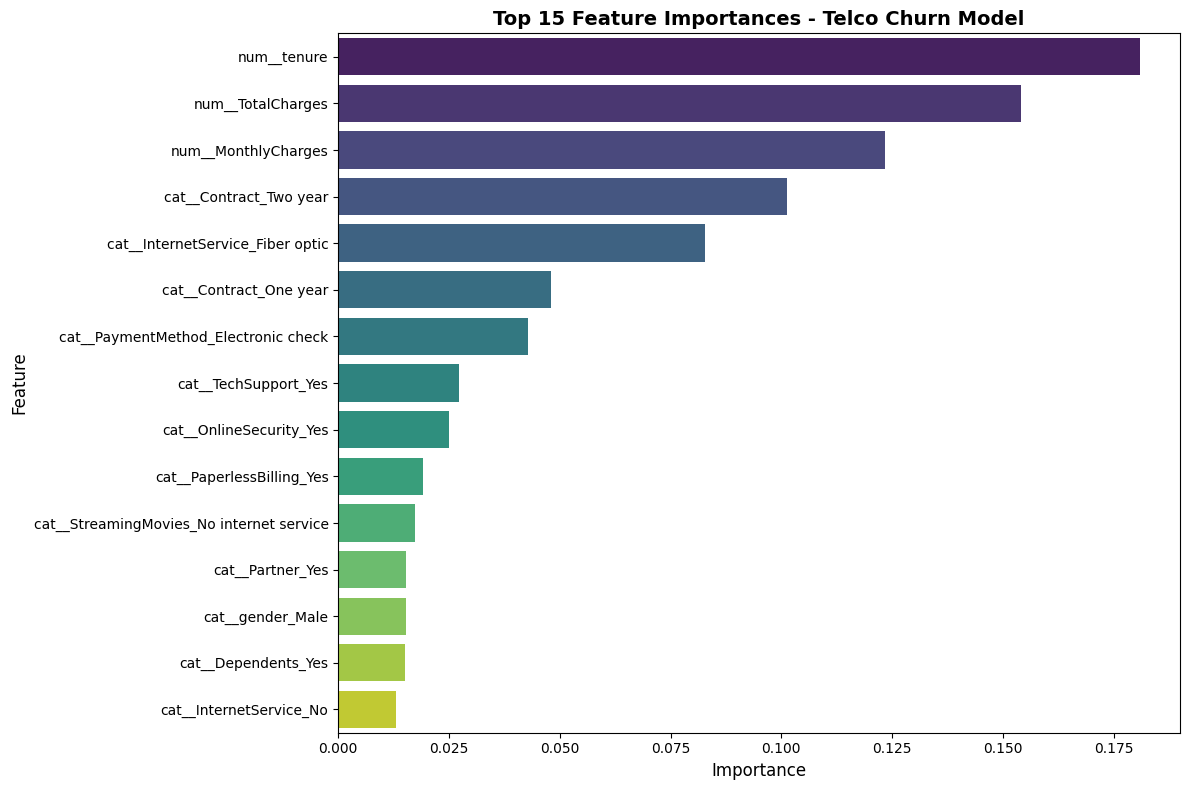


Feature Importance Summary:
Total features: 27
Average importance: 0.0370
Most important feature: num__tenure (0.1809)
Contribution of top 5 features: 64.2%


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the feature importance data
feature_imp = pd.read_csv('baseline_featureImp.csv')

# Display the top features
print("Top 10 Most Important Features:")
print(feature_imp.head(10).to_string(index=False))

# Create visualization
plt.figure(figsize=(12, 8))
top_features = feature_imp.head(15)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title('Top 15 Feature Importances - Telco Churn Model', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Summary statistics
print("\nFeature Importance Summary:")
print(f"Total features: {len(feature_imp)}")
print(f"Average importance: {feature_imp['importance'].mean():.4f}")
print(f"Most important feature: {feature_imp.iloc[0]['feature']} ({feature_imp.iloc[0]['importance']:.4f})")
print(f"Contribution of top 5 features: {feature_imp.head(5)['importance'].sum()*100:.1f}%")